# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "soufiane"
ln1 = "moutei"
fn2 = "mohammed"
ln2 = "barrahma-tlemcani"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_moutei_soufiane_and_barrahma-tlemcani_mohammed.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.sum(A * A, axis=0)
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j].copy()
        w[j] += A[:, j].T.dot(residuals) / lips_const[j]
        # update residuals:
        residuals += (old_w_j - w[j]) * A[:, j]
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.sum(A * A, axis=0)
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
        old_w_j = w[j].copy()
        w[j] -= (1. / lips_const[j]) * gradient[j]
        # update gradient:
        gradient += (w[j] - old_w_j) * gram[:, j]
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver

In [6]:
from scipy.optimize import fmin_l_bfgs_b

def loss(x, A, b):
    """Least-squares loss"""
    n = len(b)
    return ((norm(b - A.dot(x))) ** 2) / (2. * n)

def grad(x, A, b):
    """Least-squares gradient"""
    n = len(b)
    return (1. / n) * A.T.dot(A.dot(x) - b)

x_init = np.zeros(n_features)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)

print(f_min)
print(norm(grad(x_min, A, b)))

0.46638497653376565
8.500829137667533e-09


- compare the performance of cyclic and greedy CD

In [7]:
x_cyclic, obj_cyclic = cyclic_cd(A, b, n_features * 1000)
x_greedy, obj_greedy = greedy_cd(A, b, n_features * 1000)

In [8]:
print(norm(x_min - x_cyclic))
print(norm(x_min - x_greedy))

1.535580847058284e-08
1.5355803400592958e-08


Let's take a look at some plots:

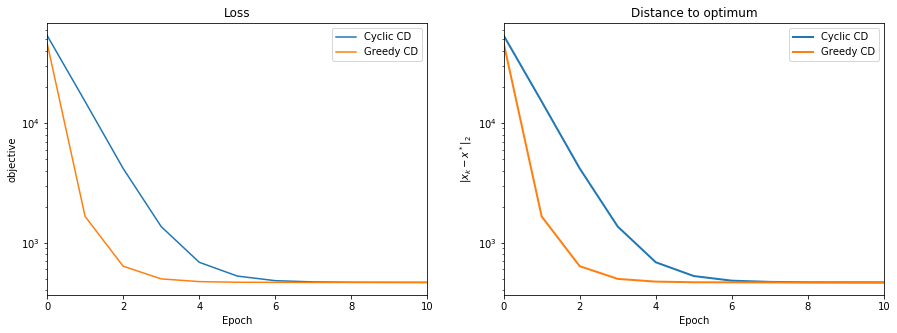

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(obj_cyclic, label='Cyclic CD')
plt.semilogy(obj_greedy, label='Greedy CD')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("objective")
plt.xlim(0,10)
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(obj_cyclic - f_min, lw=2, label='Cyclic CD')
plt.semilogy(obj_greedy - f_min, lw=2, label='Greedy CD')
plt.title("Distance to optimum")
plt.xlabel("Epoch")
plt.ylabel("$\|x_k - x^*\|_2$")
plt.xlim(0,10)
plt.legend()
    
plt.show()

Regardless of the fact that both algorithms achieve good results in reaching the minimum, the strongly convexity of the Least-squares loss allowed greedy coordinate descent to have a higher convergence rate than the cyclic algorithm.

- could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

# Answer:

- For unregularized logistic regression, the loss function is not strongly convex and thus choosing the next step in the algorithm using the gradient is not optimal.
- For OLS with 100000 features, choosing the next step in the algorithm using the gradient will be expensive in terms of computation, then, each iteration will require a large computation time which will make greedy CD computationally expensive leading to choose the cyclic CD.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

## ANSWER 1

First, for $L(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )$ we have $\nabla L(w) = -\sum_{i=1}^n \frac{y_i x_i}{1+e^{y_i x_i^\top w}}$

Then, we have 

$$
\begin{split}
\partial (L(w) + \lambda \Vert \cdot \Vert_1 (w)) & = \nabla L(w) + \lambda \partial \Vert \cdot \Vert_1 (w) \\ & = - \sum_{i=1}^n \frac{y_i x_i}{1+e^{y_i x_i^\top w}} + \lambda \partial \Vert \cdot \Vert_1 (w)
\end{split}
$$

And at $w = \mathbf{0}_p$, given the hints, we have:

$$
\partial (L(\mathbf{0}_p) + \lambda \Vert \cdot \Vert_1 (\mathbf{0}_p)) = - \frac{1}{2} \sum_{i=1}^n y_i x_i + [-\lambda,\lambda]^p
$$

So:

$$
\begin{split}
\mathbf{0}_p \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1
&\iff 0 \in \partial (L(\mathbf{0}_p) + \lambda \Vert \cdot \Vert_1 (\mathbf{0}_p))\\
&\iff \frac{1}{2} \sum_{i=1}^n y_i x_i \in [-\lambda,\lambda]^p\\
&\iff \frac 12 \Vert X^\top y \Vert_{\infty} \leq \lambda \\
&\iff \lambda \geq \lambda_\max
\end{split}
$$


We've just proofed the equivalence, which results in:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$

 

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

## ANSWER 2

We'll proceed as we did in Exercise VI from *Exercise List: Properties and examples of convexity and smoothness*.

If we write $L(w)$ as $L(w) = \sum_{i=1}^n \phi(y_i w^\top x_i)$ where $\phi (t) = \log (1 + e^{-t})$

we have directly the Hessian of $L(w)$ as: 

$$\nabla^2 L(w) = X^\top \Phi (w) X$$

Where $\Phi (w) = \text{diag}(\phi'' (y_1 w^\top x_1), \dots, \phi'' (y_n w^\top x_n))$

From one side we have: $\forall t, \ \ \phi'' (t) = \frac{e^t}{(1+e^t)^2} \leq \frac{1}{4}$

And from the other side we have the second derivative of $L$ as a function of $w_j$ equal to $X_j^\top \Phi (w) X_j$

then: 

$$
\Vert X_j^\top \Phi (w) X_j \Vert_{2} \leq \Vert X_j \Vert_2^2 \Vert \Phi (w) \Vert_2 \leq \frac{1}{4} \Vert X_j \Vert_2^2   
$$

Therefore, for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\frac{1}{4} \Vert X_j \Vert_2^2$, where $X_j$ denotes the $j$-th column of $X$.

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$L_j = \sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 + \mathrm{e}^{(Xw)_i})^2}$$
    
(why is it better?)

Implement it in the code with a `better_lc` parameter, and compare.

## ANSWER BONUS

We can write the second derivative of $L$ as a function of $w_j$ as:

$$ X_j^\top \Phi (w) X_j = \sum_{i=1}^n X_{i, j}^2 \phi'' (y_i w^\top x_i)  = \sum_{i=1}^n X_{i, j}^2 \phi'' (y_i (Xw)_i)$$

If $y_i = 1$, $\phi'' (y_i (Xw)_i) = \frac{\mathrm{e}^{(Xw)_i}}{(1 + \mathrm{e}^{(Xw)_i})^2}$

If $y_i = -1$, $\phi'' (y_i (Xw)_i) = \frac{\mathrm{e}^{-(Xw)_i}}{(1 + \mathrm{e}^{-(Xw)_i})^2} = \frac{\mathrm{e}^{-(Xw)_i}}{(1 + \mathrm{e}^{(Xw)_i})^2 \mathrm{e}^{-2(Xw)_i}} = \frac{\mathrm{e}^{(Xw)_i}}{(1 + \mathrm{e}^{(Xw)_i})^2}$

Then, 

$$ X_j^\top \Phi (w) X_j = \sum_{i=1}^n \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 + \mathrm{e}^{(Xw)_i})^2}$$

On the other hand, 

$$\sum_{i=1}^n \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 + \mathrm{e}^{(Xw)_i})^2} =  \sum_{i=1}^n X_{i, j}^2 \phi'' ((Xw)_i) \leq \sum_{i=1}^n X_{i, j}^2 \times \frac{1}{4} = \frac{1}{4} \Vert X_j \Vert_2^2$$

So, it is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$L_j = \sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 + \mathrm{e}^{(Xw)_i})^2}$$

In [10]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 10.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter, better_lc=False):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs = np.zeros(n_iter)
    
    # TODO
    lips_const = np.sum(X * X, axis=0) / 4.
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):            
            old_w_j = w[j].copy()
            # TODO
            grad_j = -X[:, j].dot(y * sigmoid(-y * Xw))
            
            if better_lc:
                sigmoid_term = sigmoid(-Xw)
                lips_const[j] = (X[:, j]**2).dot(sigmoid_term * (1 - sigmoid_term))
            
            w[j] = soft_thresh(w[j] - grad_j/lips_const[j], lamb/lips_const[j])
            
            if old_w_j != w[j]:
                Xw += (w[j] - old_w_j) * X[:, j]
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

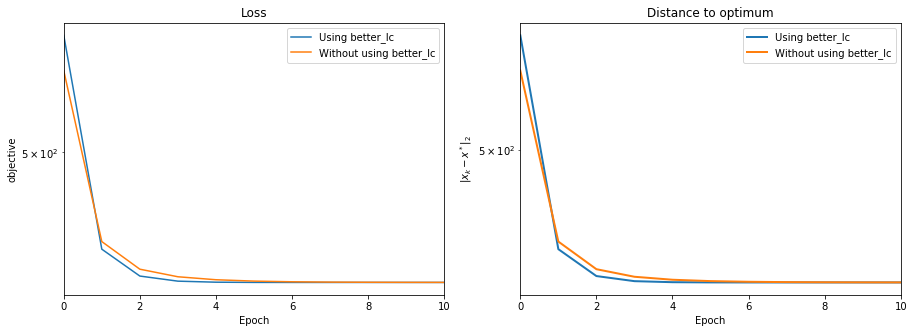

In [11]:
x_better_lc, obj_better_lc = cd_logreg(X, y, lamb, n_iter=100, better_lc=True)
x_no_better_lc, obj_no_better_lc = cd_logreg(X, y, lamb, n_iter=100)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(obj_better_lc, label='Using better_lc')
plt.semilogy(obj_no_better_lc, label='Without using better_lc')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("objective")
plt.xlim(0,10)
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(obj_better_lc - f_min, lw=2, label='Using better_lc')
plt.semilogy(obj_no_better_lc - f_min, lw=2, label='Without using better_lc')
plt.title("Distance to optimum")
plt.xlabel("Epoch")
plt.ylabel("$\|x_k - x^*\|_2$")
plt.xlim(0,10)
plt.legend()
    
plt.show()

Using `better_lc`, CD takes larger steps toward the optimal solution than without using `better_lc`, allowing the algorithm to reach faster the optimal solution.

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [12]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y[::10])

(72, 7128)
[ 1  1 -1 -1  1  1  1 -1]


In [13]:
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.
print(lambd)

16.9706461374


Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

Let's apply an ISTA algorithm as a simple proximal gradient solver for the Lasso

In [14]:
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return (norm(A, ord=2) ** 2) / 4.

def loss_logreg(x, A, b):
    bAx = b * np.dot(A, x)
    return np.sum(np.log(1. + np.exp(- bAx)))

def grad_logreg(x, A, b):
    bAx = b * np.dot(A, x)
    grad_f = np.sum(- bAx / (1 + np.exp(bAx)))
    
    return grad_f

def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * norm(x, ord=1)

def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50):
    """
    Proximal gradient descent algorithm
    """
    
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # objective history
    objectives = []
    # Current objective
    obj = f(x, X, y) + g(x, s)
    objectives.append(obj)
    
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x, X, y), s * step) # Update formula
                
        obj = f(x, X, y) + g(x, s)
        objectives.append(obj)
        
    return x, objectives

In [15]:
n_features = X.shape[1]
x0 = np.zeros(n_features)
x_ista, obj_ista = ista(x0, loss_logreg, grad_logreg, lasso, soft_thresh, 1. / lip_logreg(X), lambd, 50)

Now let's use a proximal CD solver:

In [16]:
x_cd, obj_cd = cd_logreg(X, y, lambd, n_iter=50)

Let's make now some plots to compare:

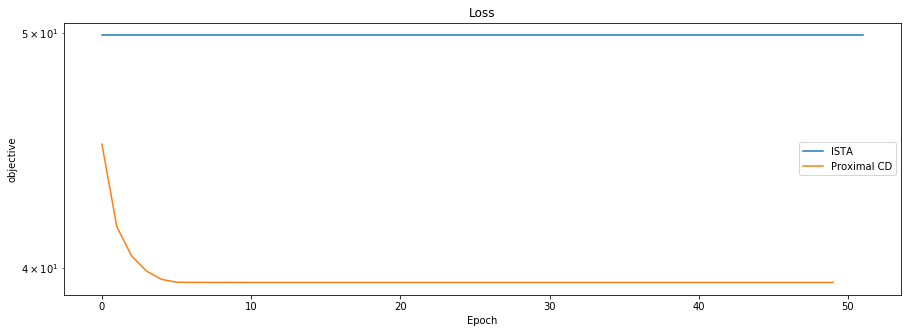

In [17]:
plt.figure(figsize=(15, 5))
plt.semilogy(obj_ista, label='ISTA')
plt.semilogy(obj_cd, label='Proximal CD')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("objective")
plt.legend()
plt.show()

Here we have a lot of features, the use of small steps and iterate over all the features in the proximal CD allowed the latter to have a faster convergence than ISTA on the same number of epochs.